In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer

import utils

In [2]:
patent_data = utils.load_patent_data('../data/patsnap_data.xlsx','sheet1')

In [3]:
patent_data

,Number,Publication Number,Title,Legal Status & Events,Current Assignee,Application Date,IPC,Patent Valuation,Abstract,Abstract_English,Claims,Title_English,CPC
0,1,US6056237A,Sonotube compatible unmanned aerial vehicle an...,Non-payment,1281329 ALBERTA LTD.,1997-06-25,B64D1/02 | B64D1/00 | B64D33/02 | B64C39/00 | ...,-,The present invention is generally comprised o...,The present invention is generally comprised o...,I claim:_x000D_\n1. A sonotube compatible unma...,Sonotube compatible unmanned aerial vehicle an...,B64C3/40 | B64C5/12 | B64C39/024 | B64D1/02 | ...
1,2,US8511606B1,Unmanned aerial vehicle base station,Granted,THE BOEING COMPANY,2009-12-09,B64D41/00,"$ 56,000","A method and apparatus comprising a platform, ...","A method and apparatus comprising a platform, ...",1. An apparatus comprising:_x000D_\na platform...,Unmanned aerial vehicle base station,B64C39/028 | B64C39/024 | B64C2201/066 | B64C2...
2,3,US8948935B1,Providing a medical support device via an unma...,Granted | Transfer,WING AVIATION LLC,2013-01-02,G06Q10/00 | B64C39/02 | G16H40/67,"$ 79,000",Embodiments described herein may relate to an ...,Embodiments described herein may relate to an ...,1. An unmanned aerial vehicle (UAV) comprising...,Providing a medical support device via an unma...,A61B5/00 | A61B19/0264 | B64C39/024 | G06F19/3...
3,4,US20100250022A1,Useful unmanned aerial vehicle,Withdrawn-Deemed,"AIR RECON, INC.",2006-12-29,G05D1/00 | B64C13/20 | G06F3/048,-,An unmanned aerial vehicle (UAV) addresses rem...,An unmanned aerial vehicle (UAV) addresses rem...,1-17. (canceled)_x000D_\n18. A method of opera...,Useful unmanned aerial vehicle,B64C2201/141 | B64C2201/145 | G05D1/0094 | G05...
4,5,US20110084162A1,Autonomous Payload Parsing Management System a...,Abandoned-Undetermined,HONEYWELL INTERNATIONAL INC.,2009-10-09,B64C29/00 | G01M1/12 | B64C17/10 | B64D37/14 |...,-,An unmanned aerial vehicle (UAV) for making pa...,An unmanned aerial vehicle (UAV) for making pa...,1. An unmanned aerial vehicle (UAV) for making...,Autonomous Payload Parsing Management System a...,B64C39/024 | B64C2201/027 | B64C2201/088 | B64...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,CN206407426U,Take precautions against earthquakes and swing...,Granted,华南智能机器人创新研究院,2016-12-30,B65D90/52 | B64C39/02,"$ 3,600",The utility model discloses a taking precautio...,The utility model discloses a taking precautio...,1.一种防震荡药箱，其特征在于，包括外壳、用来密封外壳的上盖、用于防震荡的药液分隔结构；外壳...,Take precautions against earthquakes and swing...,-
9996,9997,CN106708070A,Aerial photographing control method and apparatus,Granted,深圳市道通智能航空技术股份有限公司,2015-08-17,G05D1/08,"$ 130,000","The invention, which relates to the technical ...","The invention, which relates to the technical ...",1.一种航拍控制方法，其特征在于，包括步骤：_x000D_\n预设无人机状态数据与触发无人机...,Aerial photographing control method and apparatus,-
9997,9998,CN205864058U,A redundancy power supply for unmanned aerial ...,Non-payment,深圳光启空间技术有限公司,2016-07-14,H02J9/06,-,The utility model discloses a redundancy power...,The utility model discloses a redundancy power...,1.一种用于无人机系统的冗余电源，其特征在于，包括：_x000D_\n电源保护模块，与电源模...,A redundancy power supply for unmanned aerial ...,-
9998,9999,GB2377683A,Composite of unmanned aerial vehicles,Withdrawn-Undetermined,BAE SYSTEMS PLC,2001-07-20,B64D7/08 | B64D5/00 | B64C39/02 | F42B15/36 | ...,-,The aerial vehicle comprises a plurality of UA...,The aerial vehicle comprises a plurality of UA...,Claims_x000D_\n1 An aerial vehicle comprising ...,Composite of unmanned aerial vehicles,B64C39/024 | B64C2201/082 | B64C2201/102 | B64...


In [4]:
patent_data['Cleaned_Title'] = patent_data['Title_English'].apply(utils.clean_text)
patent_data['Cleaned_Abstract'] = patent_data['Abstract_English'].apply(utils.clean_text)

In [5]:
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

In [6]:
title_list = patent_data['Cleaned_Title'].tolist()
abstract_list = patent_data['Cleaned_Abstract'].tolist()

In [7]:
title_embeddings = model.encode(patent_data['Cleaned_Title'].tolist())
# abstract_embeddings = model.encode(patent_data['Cleaned_Abstract'].tolist())

In [8]:
# combined_list = title_list + abstract_list
# combined_list_embeddings = model.encode(combined_list)

In [9]:
# combined_embeddings = np.concatenate([title_embeddings, abstract_embeddings], axis=1)

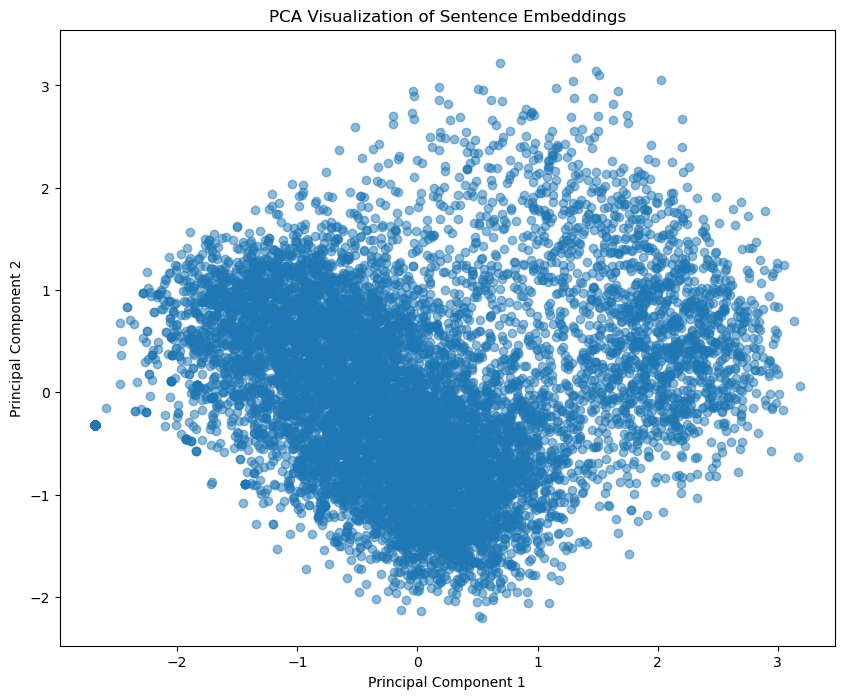

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA to reduce dimensionality
pca = PCA(n_components=2)
title_embeddings_pca = pca.fit_transform(title_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(title_embeddings_pca[:, 0], title_embeddings_pca[:, 1], alpha=0.5)
plt.title("PCA Visualization of Sentence Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

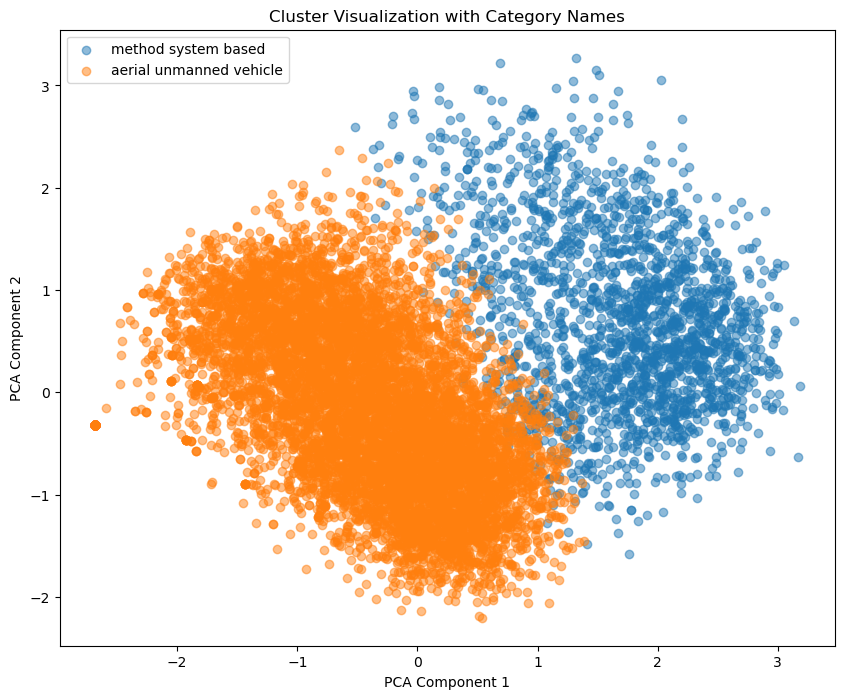

In [11]:
# Step 1: Cluster the embedded text
k = 2 
kmeans = KMeans(n_clusters=k)
cluster_labels = kmeans.fit_predict(title_embeddings)

# Step 2: Assign category names to clusters based on topic modeling
cluster_names = {}
stop_words = list(stopwords.words('english'))
for cluster_id in range(k):

    titles_in_cluster = np.array(title_list)[cluster_labels == cluster_id]

    vectorizer = CountVectorizer(stop_words=stop_words)
    X = vectorizer.fit_transform(titles_in_cluster)

    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    topic_words_idx = lda.components_[0].argsort()[-3:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]

    category_name = ' '.join(topic_words)
    cluster_names[cluster_id] = category_name

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
title_embeddings_2d = pca.fit_transform(title_embeddings)

plt.figure(figsize=(10, 8))
for cluster_id in range(k):
    plt.scatter(title_embeddings_2d[cluster_labels == cluster_id, 0], 
                title_embeddings_2d[cluster_labels == cluster_id, 1], 
                label=cluster_names[cluster_id], alpha=0.5)
plt.title("Cluster Visualization with Category Names")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

Silhouette score after PCA: 0.4537


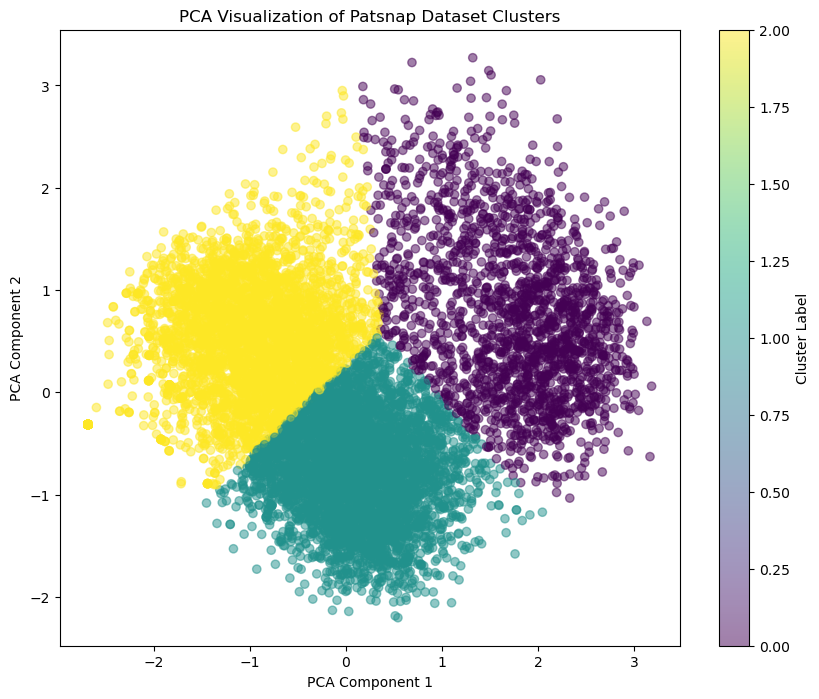

In [12]:
pca = PCA(n_components=2)
title_embeddings_pca = pca.fit_transform(title_embeddings)

kmeans_pca = KMeans(n_clusters=3, random_state=42)
cluster_labels_pca = kmeans_pca.fit_predict(title_embeddings_pca)
silhouette_avg_pca = silhouette_score(title_embeddings_pca, cluster_labels_pca)
print(f"Silhouette score after PCA: {silhouette_avg_pca:.4f}")

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(title_embeddings_pca[:, 0], title_embeddings_pca[:, 1], c=cluster_labels_pca, cmap='viridis', alpha=0.5)
plt.title("PCA Visualization of Patsnap Dataset Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

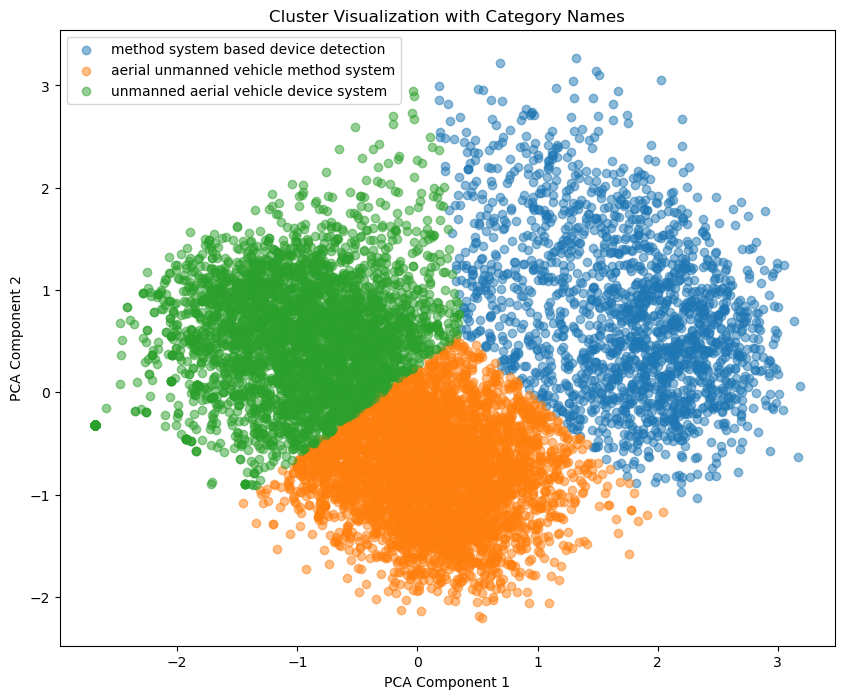

In [13]:
cluster_names = {}

for cluster_id in range(3):

    titles_in_cluster = np.array(title_list)[cluster_labels_pca == cluster_id]

    vectorizer = CountVectorizer(stop_words=stop_words)
    X = vectorizer.fit_transform(titles_in_cluster)

    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    topic_words_idx = lda.components_[0].argsort()[-5:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]

    category_name = ' '.join(topic_words)
    cluster_names[cluster_id] = category_name

plt.figure(figsize=(10, 8))
for cluster_id in range(3):
    plt.scatter(title_embeddings_pca[cluster_labels_pca == cluster_id, 0], 
                title_embeddings_pca[cluster_labels_pca == cluster_id, 1], 
                label=cluster_names[cluster_id], alpha=0.5)
plt.title("Cluster Visualization with Category Names")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

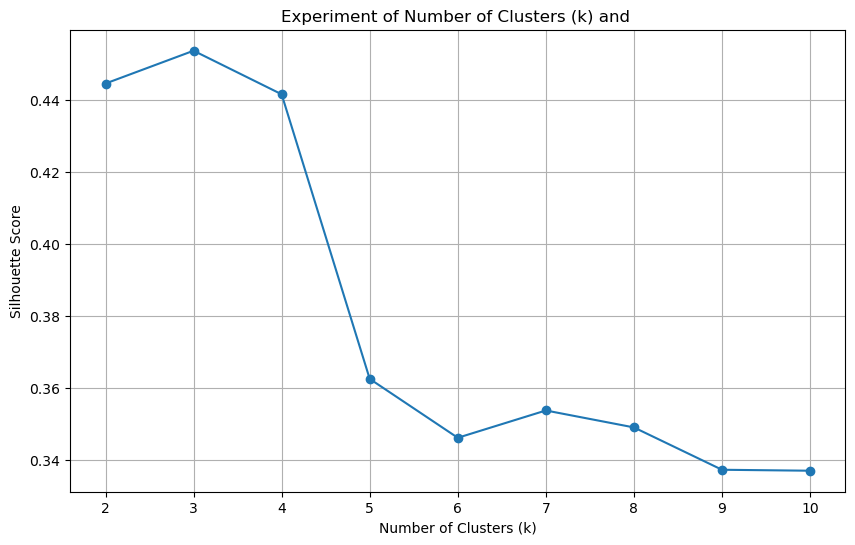

    k  Silhouette Score
0   2          0.444569
1   3          0.453683
2   4          0.441579
3   5          0.362501
4   6          0.346138
5   7          0.353726
6   8          0.349017
7   9          0.337254
8  10          0.336986


In [17]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
title_embeddings_pca = pca.fit_transform(title_embeddings)

k_values = range(2, 11)

results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(title_embeddings_pca)
    silhouette_avg = silhouette_score(title_embeddings_pca, cluster_labels)

    results.append({
        'k': k,
        'Silhouette Score': silhouette_avg
    })

results_df = pd.DataFrame(results)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['Silhouette Score'], marker='o')
plt.title('Experiment of Number of Clusters (k) and ')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

print(results_df)

In [161]:
query = 'Unmanned Aerial Vehicle Device System'

query_embedding = model.encode([query])
number_top_matches = 10000

print("Relevant Patents using Semantic Search:")
relevant_patents_df = utils.semantic_search(query, query_embedding, title_embeddings, patent_data, threshold=0.5, top_matches=number_top_matches,
                                      patent_id_col='Patent ID', pub_number_col='Publication Number',
                                      title_col='Title_English', abstract_col='Abstract_English',
                                      date_col='Application Date', cpc_col='CPC')

relevant_patents_df

Relevant Patents using Semantic Search:


,Patent ID,Score,Publication Number,Title_English,Abstract_English,Application Date,CPC
0,314,0.928649,US20120043411A1,Unmanned aerial vehicle system,"A UAV includes: a rocket body, having a rocket...",2011-05-31,B64C39/024 | B64C2201/046 | B64C2201/127 | B64...
1,1896,0.928649,CN205293077U,Unmanned aerial vehicle system,The utility model provides an unmanned aerial ...,2015-12-30,-
2,4448,0.928649,KR101610801B1,Unmanned Aerial Vehicle System,The present invention relates to an unmanned a...,2015-01-29,B64D45/00 | B64D45/06 | B64C25/32 | B64C39/02
3,4822,0.928649,CN206584232U,Unmanned aerial vehicle system,The utility model relates to an unmanned aeria...,2017-02-24,-
4,5039,0.928649,CN205524957U,Unmanned aerial vehicle system,The utility model discloses an unmanned aerial...,2016-03-15,-
...,...,...,...,...,...,...,...
8063,3066,0.500120,CN109871029A,Method for optimization of route planning of p...,The invention discloses a method for optimizat...,2019-02-21,-
8064,5867,0.500089,US20190087145A1,Contextual presentation system,A contextual presentation system is disclosed....,2018-09-19,G06F3/147 | G06K9/0063 | G06K9/00369 | B64C39/...
8065,7690,0.500085,CN109376423A,A method for tracing odor of unmanned aerial v...,The invention discloses a method for tracing t...,2018-10-19,G01N33/0065 | G06F30/20
8066,8571,0.500034,CN204979240U,Carry lifesaving articles for use unmanned aer...,The utility model discloses a carry lifesaving...,2015-09-23,-


In [162]:
print("Number of Relevant Patents:", len(relevant_patents_df))

Number of Relevant Patents: 8068


d:\Liftup\github\models\utils.py:71: FutureWarning: The default value of regex will change from True to False in a future version.
  relevant_patents_df[cpc_col] = relevant_patents_df[cpc_col].str.replace(r'[^A-Z0-9/]', '')


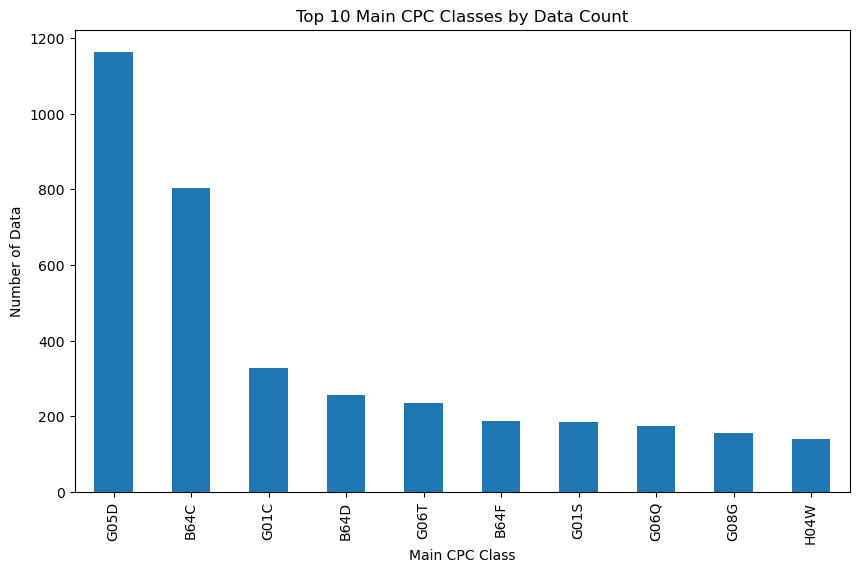

In [163]:
cpc_col = 'CPC'
cpc_counts = utils.preprocess_cpc_data(relevant_patents_df, cpc_col)
top_cpc_counts = cpc_counts.head(10)

plt.figure(figsize=(10, 6))
top_cpc_counts.plot(kind='bar')
plt.xlabel('Main CPC Class')
plt.ylabel('Number of Data')
plt.title('Top 10 Main CPC Classes by Data Count')
plt.show()

In [164]:
relevant_patents_df = utils.preprocess_date_column(relevant_patents_df, 'Application Date')

In [165]:
from scipy.optimize import curve_fit

def logistic_growth(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def plot_s_curves(relevant_patents_df, cpc_counts, time_col, top_n=5, year_range=(1990, 2050), growth_model=None, growth_model_label=None):
    if growth_model is None or growth_model_label is None:
        raise ValueError("Both growth_model and growth_model_label must be specified.")
    
    top_cpc_codes = cpc_counts.head(top_n).index
    
    for cpc_code in top_cpc_codes:
        cpc_relevant_patents = relevant_patents_df[relevant_patents_df['CPC'].str.contains(cpc_code)]
        year_counts = cpc_relevant_patents.groupby(cpc_relevant_patents[time_col].dt.year).size()
        
        if not year_counts.empty:
            future_years = np.arange(*year_range)
            patent_cumulative_counts = year_counts.cumsum()

            try:
                initial_guess = (max(patent_cumulative_counts), 0.1, year_range[0])
                bounds = ([0, 0, year_range[0]], [np.inf, np.inf, np.inf])  # Set bounds for parameters
                popt, pcov = curve_fit(growth_model, patent_cumulative_counts.index, patent_cumulative_counts, p0=initial_guess, bounds=bounds)
                future_counts = growth_model(future_years, *popt)

                print(f"For CPC {cpc_code}: Estimated Parameters (K, r, t0): {popt}")

                plt.figure(figsize=(10, 6))
                plt.plot(year_counts.index, year_counts.cumsum(), 'o', label=f'CPC {cpc_code} - Actual')
                if future_years is not None and future_counts is not None:
                    plt.plot(future_years, future_counts, label=f'CPC {cpc_code} - Predicted')

                plt.xlabel('Years')
                plt.ylabel('Cumulative Number of Patents')
                plt.title(f'S-Curve for CPC {cpc_code} ({growth_model_label})')
                plt.legend()
                plt.grid(True)
                plt.show()
            except (RuntimeError, ValueError) as e:
                print(f"Failed to fit {growth_model_label} growth model for CPC {cpc_code}: {e}")
        else:
            print(f"No data available for CPC {cpc_code}")

For CPC G05D: Estimated Parameters (K, r, t0): [1.71918067e+03 8.03539889e-01 2.01717539e+03]


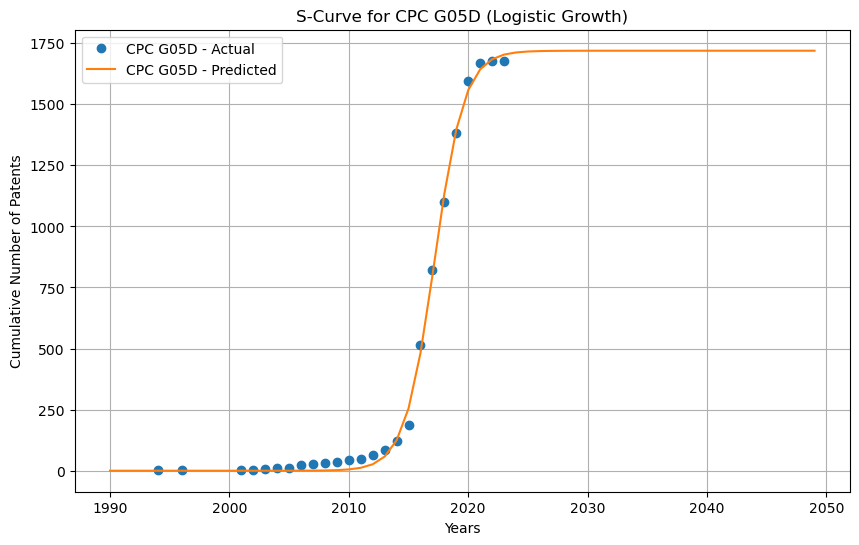

For CPC B64C: Estimated Parameters (K, r, t0): [1.62399529e+03 9.13336376e-01 2.01611022e+03]


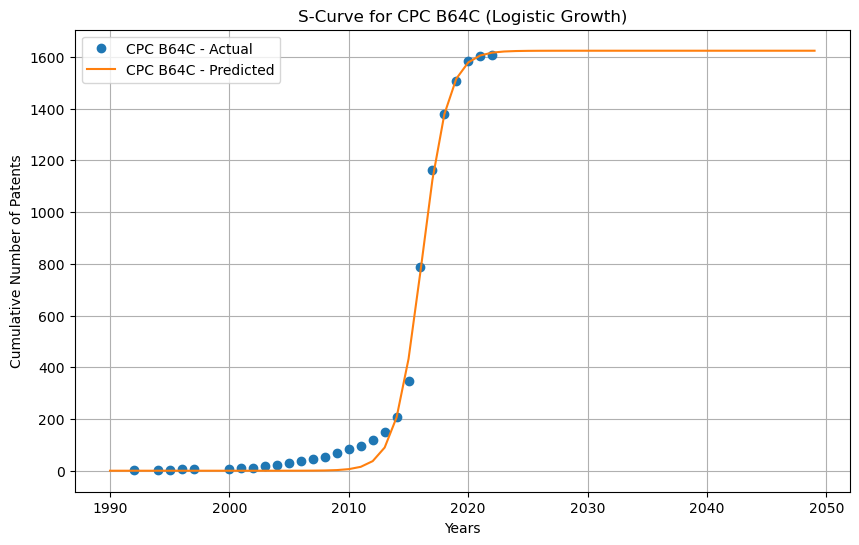

For CPC G01C: Estimated Parameters (K, r, t0): [4.90899092e+02 7.63334447e-01 2.01750510e+03]


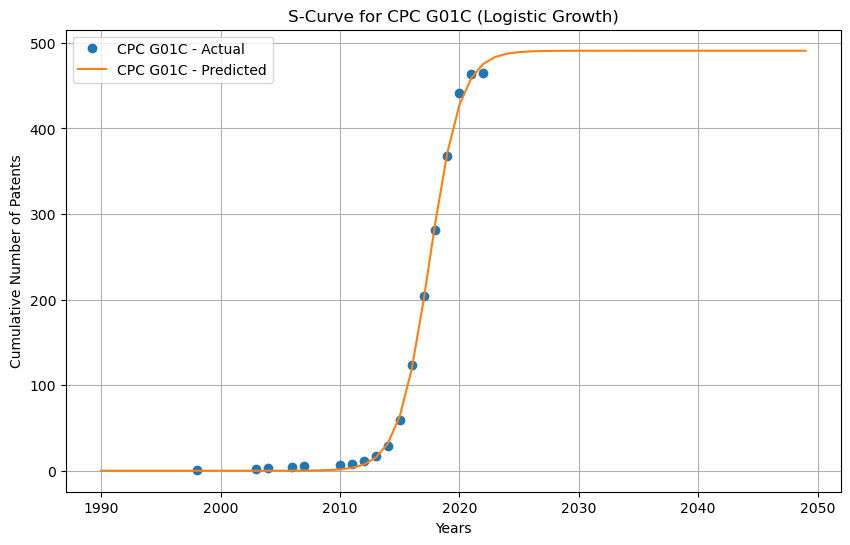

In [166]:
time_col = 'Application Date'
plot_s_curves(relevant_patents_df, cpc_counts, time_col, top_n=3,growth_model=logistic_growth, growth_model_label="Logistic Growth")